In [1]:
# Bibliotecas
%pip install google-play-scraper
%pip install pandas
%pip install matplotlib

from google_play_scraper import Sort, reviews, app
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
class_names = [
    "extremamente negativo",
    "nagativo",
    "neutro",
    "positivo",
    "extremamente positivo",
]

APPS_IDS = [
    "com.einnovation.temu",
    "com.shopee.br",
    "com.mercadolibre",
    "com.amazon.mShop.android.shopping",
    "com.zzkko",
]

SORT_ORDERS = [Sort.MOST_RELEVANT]
# SORT_ORDERS = [Sort.NEWEST]
# SORT_ORDERS = [Sort.MOST_RELEVANT, Sort.NEWEST]

TOTAL_COMMENTS = 3000
TOTAL_APPS = len(APPS_IDS)
TOTAL_COMMETS_PER_APP = TOTAL_COMMENTS // TOTAL_APPS
TOTAL_COMMETS_PER_SCORE = TOTAL_COMMETS_PER_APP // 5
TOTAL_COMMETS_PER_SORT_ORDER = TOTAL_COMMETS_PER_SCORE // len(SORT_ORDERS)

## Extração dos dados

### (Opcional) Extração das informações dos aplicativos

In [3]:
app_infos = []

# Obtem as informações dos aplicativos da lista app_ids e adiciona na lista app_infos
for app_id in APPS_IDS:
    # Obtem as informações do aplicativo
    app_info = app(app_id, lang="pt", country="br")
    # Remove os comentários
    del app_info["comments"]
    # Adiciona as informações do aplicativo na lista app_infos
    app_infos.append(app_info)

In [4]:
# Cria um DataFrame com as informações dos aplicativos
app_infos_df = pd.DataFrame(app_infos)
app_infos_df.head()

,title,description,descriptionHTML,summary,installs,minInstalls,realInstalls,score,ratings,reviews,...,contentRating,contentRatingDescription,adSupported,containsAds,released,lastUpdatedOn,updated,version,appId,url
0,Temu: Compre como bilionário,Compre na Temu e receba ofertas exclusivas. \r...,Compre na Temu e receba ofertas exclusivas. <b...,Descubra ofertas exclusivas na Temu.,500.000.000+,500000000,921830451,4.523415,10248664,93936,...,Classificação 14 anos,Conteúdo de Cariz Sexual,False,False,26 de ago. de 2022,4 de dez. de 2025,1764861380,4.11.2,com.einnovation.temu,https://play.google.com/store/apps/details?id=...
1,Shopee: 12.12 Liquida de Natal,"12.12 Liquidação de Natal, compre seus present...","12.12 Liquidação de Natal, compre seus present...",R$15 Milhões em Cupons | Sem taxa de Envio* | ...,100.000.000+,100000000,228771039,4.862383,6796278,2656568,...,Classificação Livre,None,False,False,20 de out. de 2019,3 de dez. de 2025,1764762365,3.63.23,com.shopee.br,https://play.google.com/store/apps/details?id=...
2,Mercado Livre na Black Friday,No aplicativo do Mercado Livre você pode aprov...,No aplicativo do Mercado Livre você pode aprov...,Você pode aproveitar frete gratis a partir de ...,100.000.000+,100000000,475748921,4.868784,22432246,3655759,...,Classificação 16 anos,"Violência Extrema, Conteúdo de Cariz Sexual, D...",False,False,7 de set. de 2011,3 de dez. de 2025,1764790502,10.486.2,com.mercadolibre,https://play.google.com/store/apps/details?id=...
3,Amazon Shopping,"Busque produtos, compare preços, leia avaliaçõ...","Busque produtos, compare preços, leia avaliaçõ...",Leve a Amazon com você: veja as ofertas e comp...,500.000.000+,500000000,969604058,4.402024,4376068,55769,...,Classificação Livre,None,True,True,10 de dez. de 2014,26 de nov. de 2025,1764187029,30.22.0.100,com.amazon.mShop.android.shopping,https://play.google.com/store/apps/details?id=...
4,SHEIN-Compras Online,SHEIN Grandes ofertas x Black Friday\r\nEntre ...,SHEIN Grandes ofertas x Black Friday<br>Entre ...,Save money. Live in style!,500.000.000+,500000000,879464989,4.085064,6533849,508437,...,Classificação 10 anos,Linguagem Imprópria,False,False,18 de mar. de 2014,26 de nov. de 2025,1764178800,13.8.6,com.zzkko,https://play.google.com/store/apps/details?id=...


### Extração dos reviews

In [5]:
app_reviews = []

# Obtem os comentários dos aplicativos da lista app_ids
# Vai obter X comentários para cada nota (1 a 5) e para cada tipo de ordenação (MOST_RELEVANT e NEWEST)
# Cuidado com MOST_RELEVANT e NEWES, pois se for os dois, o número de comentários será dobrado

print(f"Total de comentários por aplicativo: {TOTAL_COMMETS_PER_APP}")
print(f"Total de comentários por nota: {TOTAL_COMMETS_PER_SCORE}")
print(f"Total de comentários por tipo de ordenação: {TOTAL_COMMETS_PER_SORT_ORDER}")

for app_id in APPS_IDS:
    # Obtem os comentários dos aplicativos
    for score in range(1, 6):  # para cada nota de 1 a 5
        for sort_order in SORT_ORDERS:  # para cada tipo de ordenação , Sort.NEWEST
            result, _ = reviews(
                app_id=app_id,
                lang="pt",
                country="br",
                sort=sort_order,  # ordena os comentários por mais recentes
                count=TOTAL_COMMETS_PER_SORT_ORDER,  # número de comentários por nota
                filter_score_with=score,  # filtra os comentários pela nota
            )
            for review in result:
                review["app_id"] = app_id  # Identifica o aplicativo do comentário
                review["sortOrder"] = (
                    "most_relevant" if sort_order == Sort.MOST_RELEVANT else "newest"
                )
            # Adiciona os comentários na lista app_reviews
            app_reviews.extend(result)

# Cria um DataFrame com os comentários dos aplicativos
app_reviews_df = pd.DataFrame(app_reviews)

Total de comentários por aplicativo: 600
Total de comentários por nota: 120
Total de comentários por tipo de ordenação: 120


In [6]:
app_reviews_df.head(2)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,app_id,sortOrder
0,11645600-30c2-4eb3-927a-fb166535cb22,Agarf Nolran,https://play-lh.googleusercontent.com/a/ACg8oc...,Graças aos comentários descrevendo a imensidão...,1,4466,4.4.10,2025-11-08 18:15:01,None,NaT,4.4.10,com.einnovation.temu,most_relevant
1,76e5b2b6-cebe-4983-a257-0131d05d56fe,Munique Becker,https://play-lh.googleusercontent.com/a-/ALV-U...,Não compro mais nesse app. Toda vez que abro a...,1,963,4.7.0,2025-11-18 23:03:26,None,NaT,4.7.0,com.einnovation.temu,most_relevant


In [7]:
app_reviews_df.shape

(3000, 13)

In [8]:
app_reviews_df["score"].value_counts()

score
1    600
2    600
3    600
4    600
5    600
Name: count, dtype: int64

C:\Users\lucas\AppData\Local\Temp\ipykernel_14100\2711843471.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=score_counts.index, y=score_counts.values, palette="viridis")


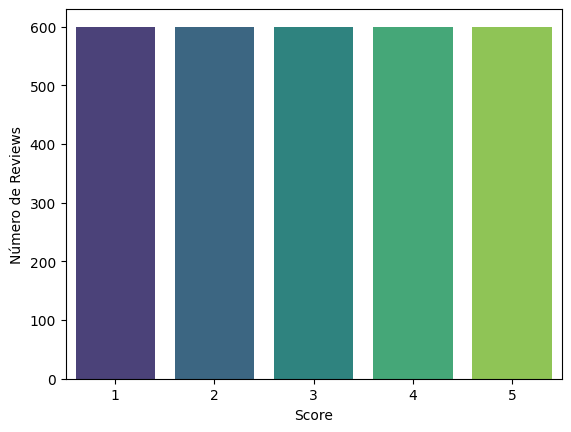

In [9]:
# Contar as avaliações por score
score_counts = app_reviews_df.score.value_counts()

# Plotar as contagens por sentimento
sns.barplot(x=score_counts.index, y=score_counts.values, palette="viridis")
plt.xlabel("Score")
plt.ylabel("Número de Reviews")
plt.show()

### Tratamento dos dados

In [10]:
# Vamos converter o conjunto de dados em sentimentos:
# extremamente negativo (0) - score = 1
# negativo (1) - score == 2
# neutral (2) - score == 3
# positive (3) - score == 4
# extremamente positivo (4) - score == 5
def get_sentiment(rating):
    rating = int(rating)
    if rating == 1:
        return 0
    elif rating == 2:
        return 1
    elif rating == 3:
        return 2
    elif rating == 4:
        return 3
    else:
        return 4

In [11]:
app_reviews_df["sentiment"] = app_reviews_df["score"].apply(get_sentiment)
app_reviews_df.sentiment.value_counts()

sentiment
0    600
1    600
2    600
3    600
4    600
Name: count, dtype: int64

C:\Users\lucas\AppData\Local\Temp\ipykernel_14100\1239558236.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=sentiment_counts.values, palette="viridis")


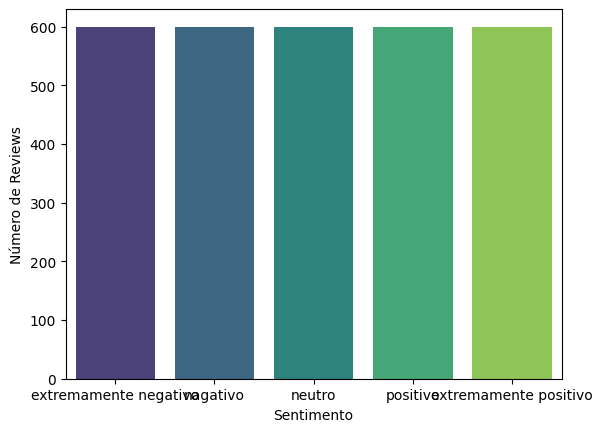

In [12]:
sentiment_counts = app_reviews_df.sentiment.value_counts()

# Plotar as contagens por sentimento
sns.barplot(x=class_names, y=sentiment_counts.values, palette="viridis")
plt.xlabel("Sentimento")
plt.ylabel("Número de Reviews")
plt.show()

In [13]:
app_reviews_df = app_reviews_df[["content", "score"]]
app_reviews_df.head()

,content,score
0,Graças aos comentários descrevendo a imensidão...,1
1,Não compro mais nesse app. Toda vez que abro a...,1
2,App horrível! É quase impossível navegar com t...,1
3,Algumas compras que fiz nunca chegaram! Os pac...,1
4,Precisam mudar muitos pontos da loja. 😡😡😡😡 1* ...,1


In [14]:
# Salva as informações dos aplicativos em um arquivo CSV
app_reviews_df.to_csv(f"reviews_{TOTAL_COMMENTS}.csv", index=None, header=True)